Braden Fisher, Finn Bergquist, Aryeh Carmi

In [ ]:
import numpy as np
import scipy.integrate as integrate
from matplotlib import rc
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import warnings
warnings.filterwarnings('ignore')

class trafficFlow:
  def __init__(self, initial_rho_bar, delta_rho, num_rho_vals=499, rho_max=1, u_max=1, x_center=0.5, lam=0.1, num_cars=10):
    self.rho_max = rho_max
    self.u_max = u_max
    self.x_center = x_center
    self.lam = lam
    self.initial_rho_bar = initial_rho_bar
    #self.grid_cells = grid_cells
    self.delta_rho = delta_rho
    self.num_rho_vals = num_rho_vals
    self.rho_spacing = 1/(num_rho_vals + 1)
    self.x_vals = np.linspace(self.rho_spacing, 1 - self.rho_spacing, num_rho_vals) #An array of the x-values at which we still store values of rho

    #self.rho_bars = np.zeros((self.grid_cells))
    #self.rho_bars_spacing = 1/(self.grid_cells)

    self.rhos = np.zeros((num_rho_vals))
    self.initialize_rho()

    self.fluxes = np.zeros((num_rho_vals))
    self.update_fluxes(self.rhos)
    #self.update_rho_bar_avgs()

    #Index 0 corresponds to i = 1/2, index 1 corresponds to i = 3/2, and so on
    self.rho_rights = np.zeros((self.num_rho_vals))
    self.rho_lefts = np.zeros((self.num_rho_vals))

    #Index 0 corresponds to i = 1/2, index 1 corresponds to i = 3/2, and so on
    self.boundary_fs = np.zeros((self.num_rho_vals))

    self.num_cars = num_cars
    '''
    self.car_positions_init = np.linspace(0.1, 1, self.num_cars, False)
    self.car_pos_arrays_at_times = []
    self.car_pos_arrays_at_times.append(self.car_positions_init)
    self.t_vals = []
    self.t_vals.append(0)
    '''

  def rho_of_x_init(self, x):
    return self.initial_rho_bar + (self.delta_rho * np.exp(-((x - self.x_center) ** 2) / self.lam ** 2))

  def initialize_rho(self):
    for i in range(self.num_rho_vals):
      self.rhos[i] = self.rho_of_x_init(self.x_vals[i])

  def update_fluxes(self, rho_vect):
    for i in range(self.num_rho_vals):
      self.fluxes[i] = rho_vect[i] * self.u_max * (1 - (rho_vect[i] / self.rho_max))

  def f_of_rho(self, rho):
    return rho * self.u_max * (1 - (rho / self.rho_max))

  def add_one_to_index(self, i, array):
    #Imposes periodic boundary conditions by checking if we are at the end of the array
    if (i == len(array) - 1):
      return 0
    else:
      return i + 1

  def subtract_one_from_index(self, i, array):
    #Imposes periodic boundary conditions by checking if we are at the beginning of the array
    if (i == 0):
      return len(array) - 1
    else:
      return i - 1

  def derivs_no_shocks(self, rho_vect, t):
    #Uses method of lines to set up vector of derivatives at every value of x where we are storing a rho value
    derivs = np.zeros((self.num_rho_vals))
    self.update_fluxes(rho_vect)
    for i in range(self.num_rho_vals):
      right_index = self.add_one_to_index(i, rho_vect)
      left_index = self.subtract_one_from_index(i, rho_vect)
      derivs[i] = -( (self.fluxes[right_index] - self.fluxes[left_index]) / (2 * self.rho_spacing)) #finite differencing
    return derivs

  def runge_kutta_no_shocks(self, t_final, n, rtol, atol):
    #A wrapper method that calls odeint() in order to solve the coupled differential equations for rho(t) at each point
    t_vals = np.linspace(0, t_final + 1, n + 1, False)
    sol = integrate.odeint(self.derivs_no_shocks, self.rhos, t_vals, rtol=rtol, atol=atol)
    return sol, t_vals

  def our_runge_kutta_no_shocks(self, rho_vect, t_final, n):
    #Our owm implementation of a Runge-Kutta stepper to use when odeint() fails
    t_vals = np.linspace(0, t_final, n + 1, False)
    rho = np.array((n + 1) * [rho_vect]) #Initialize a matrix containing a vector of rho values at each time step
    h = t_vals[1] - t_vals[0]
    for i in range(n): #Each i represents a time
        k1 = h * self.derivs_no_shocks(rho[i], t_vals[i])    
        k2 = h * self.derivs_no_shocks(rho[i] + 0.5 * k1, t_vals[i] + 0.5 * h)
        k3 = h * self.derivs_no_shocks(rho[i] + 0.5 * k2, t_vals[i] + 0.5 * h)
        k4 = h * self.derivs_no_shocks(rho[i] + k3, t_vals[i] + h)
        rho[i+1] = rho[i] + (k1 + 2*(k2 + k3) + k4) / 6 #rho[i] is an array of rho values at each x for the given time i
    return rho, t_vals

  def plot_rho_at_times_no_shocks(self, t_final, n, our_version=False, rtol=1e-5, atol=1e-5):
    #Use odeint():
    if (not our_version):
      rho_vects_at_times, t = self.runge_kutta_no_shocks(t_final, n, rtol=rtol, atol=atol)

    #Use our Runge-Kutta implementation:
    else:
      rho_vects_at_times, t = self.our_runge_kutta_no_shocks(self.rhos, t_final, n)

    
    lab_0 = "t = " + str(t[0])
    plt.plot(self.x_vals, rho_vects_at_times[0], label=lab_0)
    
    lab_1 = "t = " + str(t[1])
    plt.plot(self.x_vals, rho_vects_at_times[1], label=lab_1)

    lab_2 = "t = " + str(t[2])
    plt.plot(self.x_vals, rho_vects_at_times[2], label=lab_2)

    lab_3 = "t = " + str(t[3])
    plt.plot(self.x_vals, rho_vects_at_times[3], label=lab_3)

    
    lab_4 = "t = " + str(t[4])
    plt.plot(self.x_vals, rho_vects_at_times[4], label=lab_4)

    lab_5 = "t = " + str(t[5])
    plt.plot(self.x_vals, rho_vects_at_times[5], label=lab_5)

    '''
    #t = 10:
    lab_10 = r"$t = 10$"
    plt.plot(self.x_vals, rho_vects_at_times[10], label=lab_10)

    
    #t = 100:
    lab_100 = r"$t = 100$"
    plt.plot(self.x_vals, rho_vects_at_times[100], label=lab_100)

    
    #t = 150:
    lab_150 = r"$t = 150$"
    plt.plot(self.x_vals, rho_vects_at_times[150], label=lab_150)
    '''

    plt.xlabel(r"$x$")
    plt.ylabel(r"$\rho$")
    plt.title(r"Plots of $\rho$ at various times")
    plt.legend()

    return rho_vects_at_times

  def calc_v_analytically(self):
    #Calculates the characteristic speed using the equation from class
    return abs(self.u_max * (1 - ((2 * self.initial_rho_bar) / self.rho_max)))

  def calc_v_numerically(self, rho_t0, rho_t1, t0, t1):
    #Calculates the characteristic speed by dividing the distance a perturbation has traveled between two timestamps divided by the time taken to do so
    #t0 is the beginning distribution of rho and t1 is the ending distribution
    peak_x_0 = self.x_vals[np.argmax(rho_t0)]
    peak_x_1 = self.x_vals[np.argmax(rho_t1)]

    return abs((peak_x_1 - peak_x_0) / (t1 - t0))

  def minmod(self, a, b):
    if (a * b < 0):
      return 0
    
    if (abs(a) < abs(b)):
      return a
    
    return b

  def reconstruct(self, rho_bar_vect):
    #Implements the reconstruction step that calculates the rho values to the left and right of every boundary
    rho_lefts = np.zeros((self.num_rho_vals))
    rho_rights = np.zeros((self.num_rho_vals))
    for i in range(self.num_rho_vals):
      left_index = self.subtract_one_from_index(i, rho_bar_vect)
      right_index = self.add_one_to_index(i, rho_bar_vect)
      right_index_2 = self.add_one_to_index(right_index, rho_bar_vect)
      rho_lefts[i] = rho_bar_vect[i] + (1./2.) * self.minmod(rho_bar_vect[right_index] - rho_bar_vect[i], rho_bar_vect[i] - rho_bar_vect[left_index])
      rho_rights[i] = rho_bar_vect[right_index] - (1./2.) * self.minmod(rho_bar_vect[right_index_2] - rho_bar_vect[right_index], rho_bar_vect[right_index] - rho_bar_vect[i])
    return rho_lefts, rho_rights

  def calc_s(self, rho_left, rho_right):
    return (self.f_of_rho(rho_left) - self.f_of_rho(rho_right)) / (rho_left - rho_right)

  def get_all_fs_at_boundaries(self, rho_lefts, rho_rights):
    boundary_fs = np.zeros((self.num_rho_vals))
    for i in range(self.num_rho_vals):
      s = self.calc_s(rho_lefts[i], rho_rights[i])

      if (s >= 0):
        boundary_fs[i] = self.f_of_rho(rho_lefts[i])
      else:
        boundary_fs[i] = self.f_of_rho(rho_rights[i])

    return boundary_fs

  def eqn_star(self, f_plus, f_minus):
    return -1 * ((f_plus - f_minus) / self.rho_spacing)

  '''
  def update_car_positions(self, rho_vect, t, delta_t):
    #print(self.x_vals)
    U = np.zeros(self.num_rho_vals)
    for i in range(self.num_rho_vals):
      U[i] = self.u_max * (1 - (rho_vect[i] / self.rho_max))
    u_of_x = interp.interp1d(self.x_vals, U)

    future_positions = []
    #print(self.car_pos_arrays_at_times[-1])
    for car_pos in self.car_pos_arrays_at_times[-1]:
      if (car_pos < self.x_vals[0]):
        u = U[0]
      elif (car_pos > self.x_vals[-1]):
        u = U[-1]
      else:
        u = u_of_x(car_pos)
      new_pos = car_pos + u * delta_t
      if (new_pos >= 1):
        new_pos -= 1
      future_positions.append(new_pos)
    self.car_pos_arrays_at_times.append(np.array(future_positions))
  '''

  def derivs_shocks(self, rho_bar_vect, t, delta_t):
    derivs = np.zeros((self.num_rho_vals))
    #self.update_fluxes(rho_bar_vect)
    rho_lefts, rho_rights = self.reconstruct(rho_bar_vect)
    boundary_fs = self.get_all_fs_at_boundaries(rho_lefts, rho_rights)
    #self.t_vals.append(t)
    #self.update_car_positions(rho_bar_vect, t, delta_t)
    for i in range(self.num_rho_vals):
      derivs[i] = self.eqn_star(boundary_fs[i], boundary_fs[i-1])
    return derivs

  def runge_kutta_shocks(self, t_final, n):
    #MAY HAVE TO WRITE OUR OWN
    #A wrapper method that calls odeint() in order to solve the coupled differential equations for rho(t) at each point
    t_vals = np.linspace(0, t_final, n, False)
    delta_t = t_vals[1] - t_vals[0]
    sol = integrate.odeint(self.derivs_shocks, self.rhos, t_vals, args=(delta_t,), rtol=1e-5, atol=1e-5)
    return sol, t_vals

  def our_runge_kutta_shocks(self, rho_vect, t_final, n):
    #Our owm implementation of a Runge-Kutta stepper to use when odeint() fails
    t_vals = np.linspace(0, t_final, n, False)
    rho = np.array((n + 1) * [rho_vect]) #Initialize a matrix containing a vector of rho values at each time step
    h = t_vals[1] - t_vals[0]
    for i in range(n): #Each i represents a time
        k1 = h * self.derivs_shocks(rho[i], t_vals[i], h)    
        k2 = h * self.derivs_shocks(rho[i] + 0.5 * k1, t_vals[i] + 0.5 * h, h)
        k3 = h * self.derivs_shocks(rho[i] + 0.5 * k2, t_vals[i] + 0.5 * h, h)
        k4 = h * self.derivs_shocks(rho[i] + k3, t_vals[i] + h, h)
        rho[i+1] = rho[i] + (k1 + 2*(k2 + k3) + k4) / 6 #rho[i] is an array of the rho values at each x for a given time i
    return rho, t_vals

  '''
  def get_cell_center_x_vals(self):
    result = np.zeros((self.grid_cells))
    count = 0
    x = (1/2) * self.rho_bars_spacing
    while (count < self.grid_cells):
      result[count] = x
      x += self.rho_bars_spacing
      count += 1
    return result
  '''
  def plot_rho_at_times_shocks(self, t_final, n, our_version=False, plot_cars=False):
    #Use odeint():
    if (not our_version):
      rho_vects_at_times, t = self.runge_kutta_shocks(t_final, n)

    #Use our Runge-Kutta implementation:
    else:
      rho_vects_at_times, t = self.our_runge_kutta_shocks(self.rhos, t_final, n)

    plt.figure()

    lab_0 = "t = " + str(t[0])
    plt.plot(self.x_vals, rho_vects_at_times[0], label=lab_0)
    
    lab_1 = "t = " + str(t[2])
    plt.plot(self.x_vals, rho_vects_at_times[2], label=lab_1)

    lab_2 = "t = " + str(t[4])
    plt.plot(self.x_vals, rho_vects_at_times[4], label=lab_2)

    lab_3 = "t = " + str(t[6])
    plt.plot(self.x_vals, rho_vects_at_times[6], label=lab_3)

    lab_4 = "t = " + str(t[8])
    plt.plot(self.x_vals, rho_vects_at_times[8], label=lab_4)

    lab_5 = "t = " + str(t[10])
    plt.plot(self.x_vals, rho_vects_at_times[10], label=lab_5)

    lab_6 = "t = " + str(t[12])
    plt.plot(self.x_vals, rho_vects_at_times[12], label=lab_6)

    lab_7 = "t = " + str(t[14])
    plt.plot(self.x_vals, rho_vects_at_times[14], label=lab_7)

    plt.xlabel(r"$x$")
    plt.ylabel(r"$\overline{\rho}$")
    #plt.ylim([0, 1])
    plt.title(r"Plots of $\overline{\rho}$ at various times")
    plt.legend()

    if (plot_cars):
      self.plot_car_positions(rho_vects_at_times, t)

    return rho_vects_at_times

  def plot_car_positions(self, rho_vects_at_times, t_vect):
    car_pos_arrays_at_times = np.zeros((len(t_vect), self.num_cars))
    initial_car_positions = np.linspace(0, 1, self.num_cars, False)
    all_x_vals = np.concatenate((self.x_vals, np.array([0]), np.array([1]))) #To be able to interpolate to anywhere in the grid

    for i, t in enumerate(t_vect):
      grid_velocities = self.u_max * (1 - (rho_vects_at_times[i] / self.rho_max))

      grid_velocities = np.concatenate((grid_velocities, np.array([grid_velocities[0]]), np.array([grid_velocities[-1]]))) #Assuming the speeds at the ends of the grid are the same as the speeds one grid cell inward
      u_of_x = interp.interp1d(all_x_vals, grid_velocities)

      if (i == 0):
        delta_t = t
        car_velocities = u_of_x(initial_car_positions)
        car_pos_arrays_at_times[i] = initial_car_positions + car_velocities * delta_t
        
      else:
        delta_t = t_vect[i] - t_vect[i - 1]
        car_velocities = u_of_x(car_pos_arrays_at_times[i - 1])
        car_pos_arrays_at_times[i] = car_pos_arrays_at_times[i - 1] + car_velocities * delta_t

      for j, pos in enumerate(car_pos_arrays_at_times[i]):
          #new_pos = pos + car_velocities[i] * delta_t
        if (pos >= 1):
          pos = pos - 1
          car_pos_arrays_at_times[i][j] = pos


    plt.figure()
    for i in range(self.num_cars):
      car_positions = [t[i] for t in car_pos_arrays_at_times]
      car_positions = np.array(car_positions)
      car_positions[:-1][np.diff(car_positions) < 0] = np.nan #Don't plot a straight vertical line where periodicity is imposed
      lab = "Car " + str(i + 1)
      plt.plot(t_vect, car_positions, label=lab)
    plt.legend()
    plt.xlabel(r"$t$")
    plt.ylabel(r"$x$")
    title_str = "Positions of " + str(self.num_cars) + " cars as a function of time" 
    plt.title(title_str)
      

  def find_shock_index(self, rho_vect):
    #Finds the index of the shock by finding where there is a greatest difference in rho values across cells
    index = None
    max_diff = 0
    for i in range(self.num_rho_vals):
      diff = abs(rho_vect[i] - rho_vect[i - 1])
      if (diff > max_diff):
        max_diff = diff
        index = i
    return i

  def calc_s_numerically(self, rho_vect_t0, rho_vect_t1, t0, t1):
    '''
    shock_index_t0 = self.find_shock_index(rho_vect_t0)
    print(shock_index_t0)
    shock_index_t1 = self.find_shock_index(rho_vect_t1)
    print(shock_index_t1)
    return abs((self.x_vals[shock_index_t1] - self.x_vals[shock_index_t0]) / (t1 - t0))
    '''
    peak_x_0 = self.x_vals[np.argmax(rho_vect_t0)]
    peak_x_1 = self.x_vals[np.argmax(rho_vect_t1)]

    if (peak_x_1 > peak_x_0):
      peak_x_1 -= 1

    return abs((peak_x_1 - peak_x_0) / (t1 - t0))

  def calc_s_analytically(self, rho_vect):
    shock_index = np.argmax(rho_vect)
    rho_lefts, rho_rights = self.reconstruct(rho_vect)
    return abs((self.f_of_rho(rho_lefts[shock_index]) - self.f_of_rho(rho_rights[shock_index])) / (rho_lefts[shock_index] - rho_rights[shock_index]))

  '''
  def plot_car_positions(self):
    for i in range(self.num_cars):
      car_positions = [t[i] for t in self.car_pos_arrays_at_times]
      car_positions = np.array(car_positions)
      car_positions[:-1][np.diff(car_positions) < 0] = np.nan #Don't plot a straight vertical line where periodicity is imposed
      plt.plot(self.t_vals[0::1], car_positions[0::1])


    plt.xlabel(r"$t$")
    plt.ylabel(r"$x$")
    plt.xlim([0, 0.25])
    plt.title("Positions of each tracked car over time")
  '''

First, we will try the given example, where $̅ρ = ρ_{max} / 2$ and $δρ = 10^{-3}ρ_{max}$.

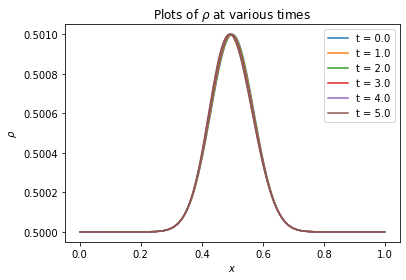

In [ ]:
traffic = trafficFlow(1./2., 1e-3)
#print(traffic.x_vals)
#print(traffic.rho_bars)
#print(traffic.rhos)

#traffic.update_rho_bar_avgs()
#print(traffic.rho_bars)
rho_vects = traffic.plot_rho_at_times_no_shocks(10, 10)

We would expect the perturbation to remain the same over time, as the characteristic speed would be $0$ analytically. However, the perturbation seems to be travelling over time slightly, but this may be due to our assumption that $δρ$ is small enough that we only need the first-order term in the Taylor expansion in order to calculate the characteristic speed $v$ analytically, where $δρ$ is actually not small enough to see that visually here. Let's check to see if this is the case by examining the same situation with a smaller value for $δρ$, such as $10^{-4}$.

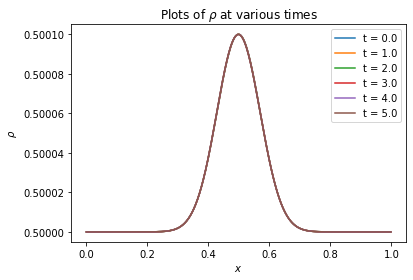

In [ ]:
traffic = trafficFlow(1./2., 1e-4)
rho_vects = traffic.plot_rho_at_times_no_shocks(10, 10)


Now, as expected, the perturbation remains in the same place because $δρ$ is small enough that our expansion from class applies. We will now set $̅ρ$ to something other than $\rho_{max} / 2$, such as $̅ρ = 0.6 \rho_{max}$. We will keep the perturbation the same, at $δρ = 10^{-3}$.

The analytical characteristic speed is 0.19999999999999996
The numerical characteristic speed calculated between t = 0 and t = 1 is 0.202


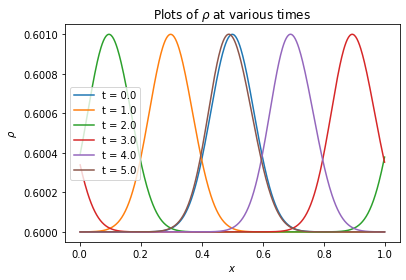

In [ ]:
traffic = trafficFlow(0.6, 1e-3)
rho_vects = traffic.plot_rho_at_times_no_shocks(5, 5, rtol=1e-8, atol=1e-8)

print("The analytical characteristic speed is", traffic.calc_v_analytically())
print("The numerical characteristic speed calculated between t = 0 and t = 1 is", traffic.calc_v_numerically(rho_vects[0], rho_vects[1], 0, 1))

We see that the numerical value of the characteristic speed, which is calculated as the distance the peak has traveled in one time unit, is very close to the characteristic speed calculated with our analytical result from class. The slight difference is likely due to the higher-order terms in the expansion that we did not consider in the analytical calculation. The perturbation is slightly changing shape as it propagates - it is starting to "tip over" to the left more as time goes on.

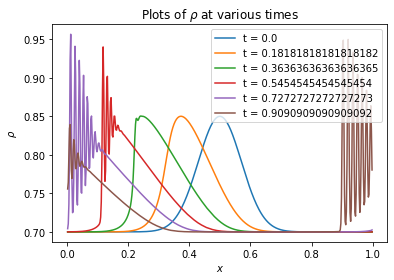

In [ ]:
traffic = trafficFlow(0.7, 0.15)
rho_vects = traffic.plot_rho_at_times_no_shocks(1, 10)


Now, we see a shock forming, and our code is becoming unstable at the location of the shock. So, let's implement a High-Resolution Shock-Capturing Scheme (HRSC) that deals with the shock:

The analytical shock front speed measured at t = 0.7 is 0.6895468260752635
The numerical shock front speed calculated between t = 0.6 and t = 0.7 is 0.5800000000000001


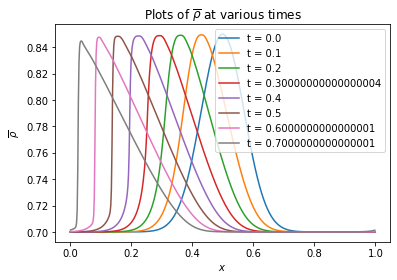

In [ ]:
traffic = trafficFlow(0.7, 0.15)
rho_vects = traffic.plot_rho_at_times_shocks(1, 20)

print("The analytical shock front speed measured at t = 0.7 is", traffic.calc_s_analytically(rho_vects[14]))
print("The numerical shock front speed calculated between t = 0.6 and t = 0.7 is", traffic.calc_s_numerically(rho_vects[12], rho_vects[14], 0.6, 0.7))

Now, there is higher resolution at the location of the shock. The shock front speed $s$ was calculated analytically using the equation from class at the location of the shock (the tip of each graph where $̅ρ$ becomes discontinuous), and was calculated numerically by dividing the distance between two successive shock fronts by the time between the two measurements. These values are roughly the same, on the order of $0.6$. Let's test with the parameters $̅ρ = 0.3ρ_{max}$ and $δρ = -0.2\rho_{max}$.

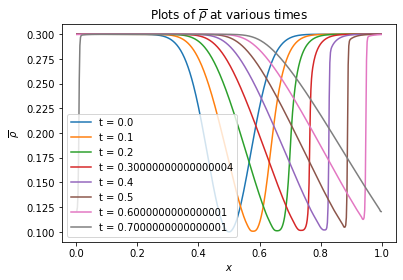

In [ ]:
traffic = trafficFlow(0.3, -0.2)
rho_vects = traffic.plot_rho_at_times_shocks(1, 20)

Now, the shock has flipped, and the perturbation is such that there is a decrease in the car density, which now moves to the right over time. Finally, let's go back to the example with $̅ρ = 0.75ρ_{max}$ and $δρ = 0.15ρ_{max}$ and plot the locations of two cars over time:

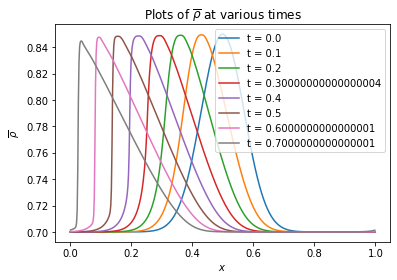

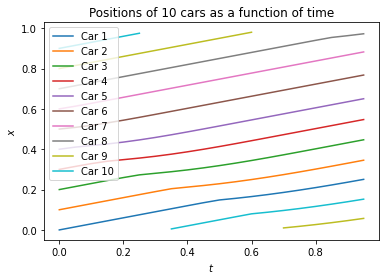

In [ ]:
traffic = trafficFlow(0.7, 0.15)
rho_vects = traffic.plot_rho_at_times_shocks(1, 20, plot_cars=True)

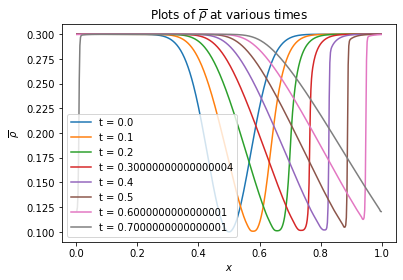

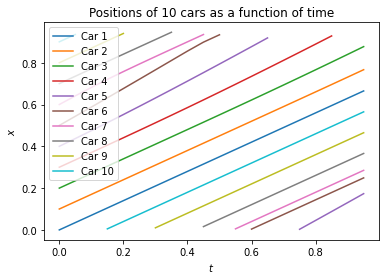

In [ ]:
traffic = trafficFlow(0.3, -0.2)
rho_vects = traffic.plot_rho_at_times_shocks(1, 20, plot_cars=True)

Once the shock starts forming, which really starts to take place around $t = 0.2$ or so, the slopes of the cars' spacetime diagrams change abruptly, as we would expect as the shock is forming. When the shock is forming, cars must change their speed very rapidly, which is shown by the very quick changes in the slopes of these lines.

In [ ]:
print(np.linspace(0.1, 1, 2, False))

[0.1  0.55]
